In [2]:
import pystan
from pystan import StanModel
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from psis import psisloo
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, KFold
from sklearn.utils import resample

In [3]:
projects = pd.read_csv("projects.csv")
display(HTML(projects.head(100).to_html(max_rows=100)))

C:\Users\Matias\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000,2017-09-02 04:43:57,2421,failed,15,US,100,NaN,NaN,NaN,NaN
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21 18:30:44,1000,2014-12-01 18:30:44,1205,successful,16,US,1205,NaN,NaN,NaN,NaN
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17 19:05:12,25000,2016-02-01 20:05:12,453,failed,40,US,453,NaN,NaN,NaN,NaN
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29 18:14:43,125000,2014-04-24 18:14:43,8233,canceled,58,US,8233,NaN,NaN,NaN,NaN
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10 21:55:48,65000,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,NaN,NaN,NaN,NaN


#### Run below cells after making changes

### Get the data

In [4]:
print(projects.columns)
print(projects.index)
print(projects[(projects['category'] == 'Fashion') | (projects['category'] == 'Apparel')].shape)
# Only keep projects that are in suitable categories
projects = projects[(projects['category'] == 'Fashion') | (projects['category'] == 'Apparel')]


Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')
RangeIndex(start=0, stop=378648, step=1)
(15688, 17)


In [4]:
pm = np.array(projects) #All project data
pm = np.delete(pm, (0), axis=0) #Delete top row

In [5]:
pm = np.delete(pm, (0,1,2,3,4,5,7,11,12,13,14,15,16), axis=1) #Delete non needed columns

print(pm.shape) #Shape of the data

(15687, 4)


### Sanitize and display the data

In [6]:
success_idx = pm[:,2] == "successful" #Tuple of all indexes that are successful
failed_idx = pm[:,2] == "failed" #Tuple of all indexes that failed
print("Data points before processing: ",pm.shape[0])

#Remove all rows where the end result is not successful or failed
remove_idx = np.where(np.logical_or(success_idx,failed_idx)==False)
pm = np.delete(pm, remove_idx, axis=0)
print("Data points after removing non success/fail cases: ",pm.shape[0],"\n")

#Find new indexes for success and fail cases
success_idx = pm[:,2] == "successful"
failed_idx = pm[:,2] == "failed"

#Replace failed values with 0, success with 0 and convert whole matrix to numeric values
pm[success_idx,2] = 1
pm[failed_idx,2] = 0
pm = pm.astype(float)
pm = pm.astype(int)

#Remove all rows where the data points are below a threshold
remove_idx = np.where(pm[:,3] < 10)
pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,0] > 100000)
#pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,0] < 50000)
#pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,1] > 100000)
#pm = np.delete(pm, remove_idx, axis=0)

#remove_idx = np.where(pm[:,1] < 50000)
#pm = np.delete(pm, remove_idx, axis=0)

unique_backers_count = np.unique(pm[:,3]).shape[0] #Unique backers amount count
evaluated_projets = pm.shape[0] #All projects evaluated

print("Data points after removing data not falling to minimum threshold: ",evaluated_projets)


pd.DataFrame(pm).to_csv("sanitized.csv",header=False, index=False)
sanitized = pd.read_csv("sanitized.csv", header=None, names=["Goal","Pledged","Success","Backers"])
display(HTML(sanitized.head(100).to_html(max_rows=100)))

Data points before processing:  15687
Data points after removing non success/fail cases:  13664 

Data points after removing data not falling to minimum threshold:  5754


,Goal,Pledged,Success,Backers
0,500,754,1,36
1,5400,5858,1,131
2,1750,1805,1,25
3,36000,91003,1,750
4,3000,23079,1,140
5,3286,3776,1,44
6,1750,2190,1,51
7,1500,279,0,12
8,20000,1034,0,21
9,20000,20339,1,213


### Scale down the data

### Format the data to be inserted in the model

In [6]:
groups, indices, inverse, group_amounts= np.unique(pm[:,3], return_index=True, return_inverse=True, return_counts=True) 

success_per_group = np.zeros((unique_backers_count,1)) #Empty array for success amounts per unique group
success_column = pm[:,2] #Column where the success/fail values live

group_means = np.zeros((unique_backers_count,1))
group_stds = np.zeros((unique_backers_count,1))

In [7]:
for i in range(evaluated_projets):
    if (success_column[i]==1): #Check whether a particular project has succeeded
        success_per_group[inverse[i]] = success_per_group[inverse[i],0] + 1 #If yes, increment the success amount of the group
# Redundant

In [8]:
for i in range(unique_backers_count):
    ind = np.where(pm[:,3] == groups[i])
    
    group_means[i] += np.mean(pm[ind,0])
    group_stds[i] += np.std(pm[ind,0])
# Redundant

In [9]:
#group_log_values = np.log(groups) #Backer counts in the log scale as we are using binomial logit
#success_int = success_per_group.astype(int)


s = np.asarray(pm[:,3]) # Backers / supporters
g = np.asarray(pm[:,0]) # Goal
p = np.asarray(pm[:,1]) # Pledged
y = np.asarray(pm[:,2]) # Success

N = pm.shape[0] # Size of data
n = np.asarray(np.ones((N,1))[:,0]).astype(int) # Projects per group, always = 1


project_stan_data = {
    's': np.log(s),
    'g': np.log(g),
    'y': y,
    'N': N,
    'n': n
}
print(pm.shape)
print(n)

(5754, 4)
[1 1 1 ... 1 1 1]


### Data analysis before fitting model

In [10]:
pm = resample(pm,n_samples=100,random_state=0)

Backer counts histogram
196.1
398.1144182267204


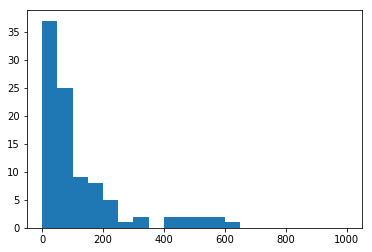

In [11]:
plt.hist(pm[:,3],bins=20, range=[0,1000]);
print("Backer counts histogram")
print(np.median(pm[:,3]))
print(np.std(pm[:,3]))

Project goals histogram
8000.0
54581.23583667009


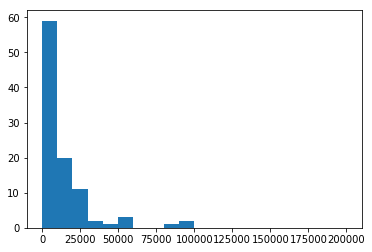

In [12]:
goals = pm[:,0]
print("Project goals histogram")
plt.hist(goals, bins=20,range=[0,200000]);
print(np.median(goals))
print(np.std(goals))

Projects pledged histogram
105.80618427486465


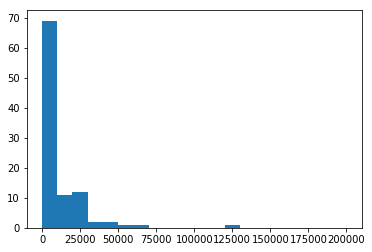

In [13]:
pledged = pm[:,1]
print("Projects pledged histogram")
plt.hist(pledged, bins=20,range=[0,200000]);
print(np.mean(pledged/pm[:,3]))

(100, 4)


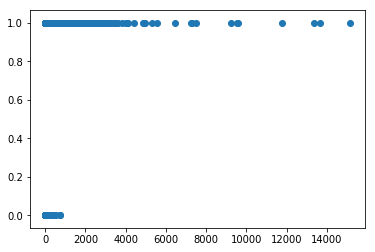

In [14]:
plt.figure()
plt.scatter(s,y)
print(np.sum(y==True))
print(np.sum(y==False))

### Define the model

In [15]:
stan_content = """

data {
    int<lower=0> N; // amount of projects
    int n[N]; //projects 
    vector [N] s; // backers
    vector [N] g; // goal
    int<lower=0,upper=1> y[N]; // success
}

parameters {
    real a;
    real<lower=0> b;
    real<lower=0> c;
}

model {
    b ~ normal(45,600);
    c ~ normal(8000, 30000);
    y ~ binomial_logit(N, a + b*s + c*g);
}

generated quantities {
  vector[N] log_lik;
  
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + b*s[i]+ c*g[i]);
  }
}


"""



stan_file_sepa = open("model.stan", "w")
stan_file_sepa.write(stan_content)
stan_file_sepa.close()

### Fit the data to the model and print summary

In [18]:
model = pystan.StanModel(file='model.stan')
fit = model.sampling(data=project_stan_data)
samples = fit.extract(permuted=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8e2db46a9a87d2e968d4a67755ef61a6 NOW.
C:\Users\Matias\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Matias\AppData\Local\Temp\tmpmjeja56q\stanfit4anon_model_8e2db46a9a87d2e968d4a67755ef61a6_7271913820742818589.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_8e2db46a9a87d2e968d4a67755ef61a6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a             -10.43  1.4e-3   0.06 -10.54 -10.47 -10.43  -10.4 -10.33   1478    1.0
b                0.3  3.1e-4   0.01   0.28   0.29    0.3   0.31   0.32   1454    1.0
c             5.6e-4  1.2e-5 5.5e-4 1.2e-5 1.6e-4 3.8e-4 7.7e-4 2.1e-3   2251    1.0
log_lik[1]     -9.36  3.8e-4   0.02   -9.4  -9.37  -9.36  -9.35  -9.32   2624    1.0
log_lik[2]     -8.98  2.5e-4   0.02  -9.01  -8.99  -8.98  -8.96  -8.94   4887    1.0
log_lik[3]     -9.47  4.7e-4   0.02  -9.51  -9.48  -9.47  -9.46  -9.43   2188    1.0
log_lik[4]     -8.45  6.9e-4   0.03  -8.51  -8.47  -8.45  -8.43   -8.4   1960    1.0
log_lik[5]     -8.96  2.5e-4   0.02  -8.99  -8.97  -8.96  -8.94  -8.92   4787    1.0
log_lik[6]      -9.3  3.3e-4   0.02  -9.34  -9

### Amount of backers needed to succeed with 90% probability

NameError: name 'samples' is not defined

(array([  36.,  214.,  718., 1079., 1073.,  642.,  188.,   34.,   12.,
           4.]),
 array([44.41787546, 44.74669566, 45.07551586, 45.40433606, 45.73315626,
        46.06197646, 46.39079666, 46.71961686, 47.04843706, 47.37725726,
        47.70607745]),
 <a list of 10 Patch objects>)

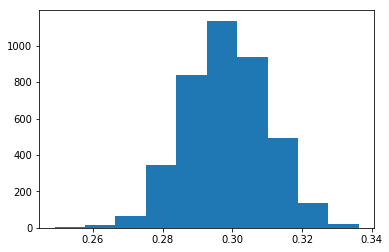

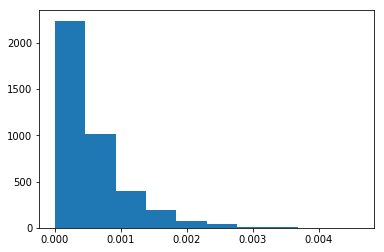

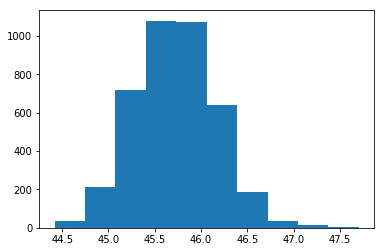

In [1]:
a_samples = samples['a']
b_samples = samples['b']
c_samples = samples['c']

#a_samples2 = samples2['a']
#b_samples2 = samples2['b']
#c_samples2 = samples2['c']
#d_samples2 = samples2['d']


goal = np.log(200000)

#prob = (2.19-a_samples-c_samples*goal) / b_samples # Distribution when the probability of success is 90%
prob = np.log((2.19-a_samples-c_samples) / b_samples)*goal # Distribution when the probability of success is 90%


print(np.mean(prob))
#plt.hist(a_samples)
plt.figure()
plt.hist(b_samples)
plt.figure()
plt.hist(c_samples)
plt.figure()
plt.hist(prob)
#plt.figure()
#plt.hist(samples['log_lik'])

#prob2 = np.exp((2.19-a_samples2-c_samples) / (b_samples2+d_samples2))#*goal #Distribution when the probability of success is 90%
#plt.hist(prob);

### PSIS-LOO analysis

In [20]:
print("PSIS-LOO value is", psisloo(samples['log_lik'])[0])

PSIS-LOO value is -31425.429574412992



 k-values plotted


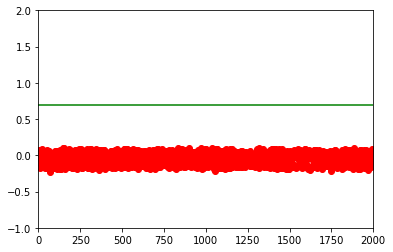

In [21]:
print("\n k-values plotted")
plt.plot(psisloo(samples['log_lik'])[2],'ro')
plt.axis([0, 2000, -1, 2])
plt.axhline(0.7, color='g');

In [22]:
print(np.mean(b_samples))
print(np.mean(c_samples))

0.2983253144296415
0.0005557761321079125
